### Carga de librerías

In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from keras import regularizers
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder # one-hot encoding for age
from keras.utils.np_utils import to_categorical


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd /content/drive/MyDrive/Facial Age Recognition/face_age
image_path = os.getcwd() + '/face_age/'

/content/drive/.shortcut-targets-by-id/1jR5qjUZ6Jhg4Cict2in9N8gapcetxYEZ/Facial Age Recognition/face_age


In [3]:
##MONI

%cd /content/drive/MyDrive/Facial Age Recognition
image_path = os.getcwd() + '/face_age/'

/content/drive/.shortcut-targets-by-id/1jR5qjUZ6Jhg4Cict2in9N8gapcetxYEZ/Facial Age Recognition


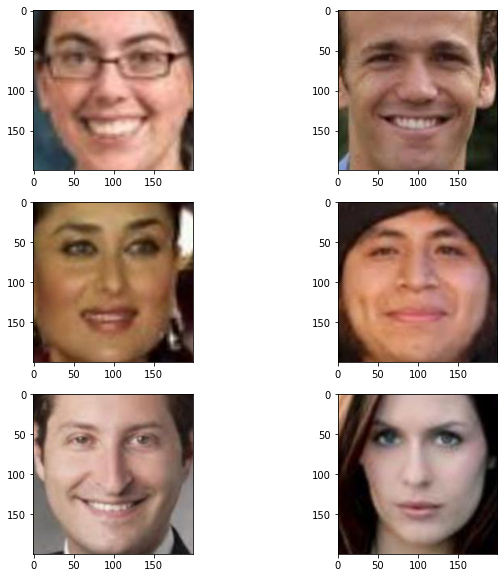

In [4]:
# Take a look at some images

def see_sample_images(age, number_of_images):
    plt.figure(figsize=(10,10))
    age_folder = image_path + age
    images = os.listdir(age_folder)[:number_of_images]
    for i in range(number_of_images):
        file = mpimg.imread(age_folder +'/'+ images[i])
        plt.subplot(number_of_images/2,2,i+1)
        plt.imshow(file)

see_sample_images("033",6)

In [5]:
X = []
Y = []
width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for folder_name,_,filenames in os.walk(image_path):
    if folder_name !="face_age" and folder_name != 'Data':
        for file in filenames:
            file_path = folder_name +"/"+ file
            image = Image.open(file_path)
            image = image.convert('RGB')
            image = image.resize((width, height))
            X.append(np.array(image))
            Y.append(int(folder_name[-3:])
            )
    else:
        pass

In [6]:
# Normalise input data to range [0,1]
X = np.array(X)
X = X.astype('float32')
X /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))

Y = np.array(Y)

Min: 0.000, Max: 1.000


In [8]:
# os.mkdir("Data")

try:
    os.remove("Data")
#     os.remove("Data/X.npy")
#     os.remove("Data/Y.npy")
#     os.remove("Data/X_train.npy")
#     os.remove("Data/Y_train.npy")
#     os.remove("Data/X_test.npy")
#     os.remove("Data/Y_test.npy")
#     os.remove("Data/X_val.npy")
#     os.remove("Data/Y_val.npy")
except OSError:
    pass

In [7]:
# Train, validation and testing split (70/15/15)
test_size = 0.3
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=test_size, 
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=Y)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [8]:
# save to files
# os.mkdir("Data")
np.save('Data/X_train.npy', X_train)
np.save('Data/Y_train.npy', Y_train)
np.save('Data/X_val.npy', X_val)
np.save('Data/Y_val.npy', Y_val)
np.save('Data/X_test.npy', X_test)
np.save('Data/Y_test.npy', Y_test)

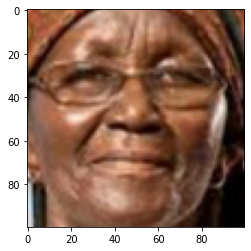

In [11]:
plt.imshow(X_train[33])

In [12]:
Y_train[33]

75

In [13]:
type(X_test)

numpy.ndarray

### Preprocesamiento

In [9]:
# Apply Image Augmentation

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    fill_mode="nearest")

In [15]:
# len(train_datagen)
# len(test_datagen)


TypeError: ignored

### Callbacks e hiperparámetros

In [10]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=8, # wait for 5 epochs
                                min_delta = 0.005, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

# hyperparameters
lr = 0.001
epochs = 100 # setting it to a low number since this is for Kaggle, ideally you should set this to a higher number ~ 100 so that the model overfits training data, and then apply the elbow methods to select the best params on validaion data
batch_size = 128
results = {}
input_shape =[width,height]
num_of_ages = 90

### Modelos 

#### Modelo 1. CNN

In [25]:
Adam = keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)

In [26]:
del x

In [27]:
# nb_filters = 8
# nb_conv = 5
# image_size = 50

# model = Sequential()
# model.add(Conv2D(filters=nb_filters,
#                  kernel_size=(3,3),
#                  activation="relu",
#                  padding="valid",
#                  kernel_regularizer=regularizers.l2(0.00001),
#                  input_shape=(input_shape[0], input_shape[1], 3)))

# model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(1,activation="linear")) 


inputs = tensorflow.keras.Input(shape=(100, 100, 3))

x = tensorflow.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tensorflow.keras.layers.BatchNormalization()(x)
x = tensorflow.keras.layers.MaxPool2D()(x)
x = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tensorflow.keras.layers.MaxPool2D()(x)
x = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tensorflow.keras.layers.MaxPool2D()(x)
x = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tensorflow.keras.layers.MaxPool2D()(x)
x = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tensorflow.keras.layers.MaxPool2D()(x)
x = tensorflow.keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(rate = 0.5)(x)
x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
outputs = tensorflow.keras.layers.Dense(1, activation='linear')(x)

model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam",loss="mean_absolute_error",metrics=['mean_absolute_error'])

model_history = model.fit_generator(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), # use augmented images
            validation_data = (X_val,Y_val),
            steps_per_epoch=X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)






################################################################################################################################
# model.add(Conv2D(nb_filters, 
#                  nb_conv, 
#                  nb_conv,
#                  input_shape = (3, image_size, image_size) ) )
# model.add(Dense(1,activation="relu"))  
# model.add(Conv2D(nb_filters, nb_conv, nb_conv))
# model.add(Dense(1,activation="relu")) 
# model.add(Conv2D(nb_filters, nb_conv, nb_conv))
# model.add(Dense(1,activation="relu")) 
# model.add(Conv2D(nb_filters, nb_conv, nb_conv))
# model.add(activation('relu'))
# model.add(Dropout(0.25))
# model.add(Conv2D(nb_filters*2, nb_conv, nb_conv))
# model.add(activation('relu'))
# model.add(Conv2D(nb_filters*2, nb_conv, nb_conv))
# model.add(activation('relu'))
# model.add(Conv2D(nb_filters*2, nb_conv, nb_conv))
# model.add(activation('relu'))
# model.add(Conv2D(nb_filters*2, nb_conv, nb_conv))
# model.add(activation('relu'))
# model.add(Dropout(0.5))
# model.add(Flatten())
# model.add(Dense(256))
# model.add(activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128))
# model.add(activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(activation('linear'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100
53/53 [==============================] - 74s 1s/step - loss: 22.7585 - mean_absolute_error: 22.7585 - val_loss: 27.1669 - val_mean_absolute_error: 27.1669 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 73s 1s/step - loss: 19.1156 - mean_absolute_error: 19.1156 - val_loss: 27.2715 - val_mean_absolute_error: 27.2715 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 73s 1s/step - loss: 17.8600 - mean_absolute_error: 17.8600 - val_loss: 28.0259 - val_mean_absolute_error: 28.0259 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - ETA: 0s - loss: 17.0417 - mean_absolute_error: 17.0417
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
53/53 [==============================] - 73s 1s/step - loss: 17.0417 - mean_absolute_error: 17.0417 - val_loss: 27.8069 - val_mean_absolute_error: 27.8069 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - 73s 1s/step - loss: 16.3252 - mean_absolute_error: 16.

In [ ]:
# baseline_adam_train_loss = model_history.history["loss"]
# baseline_adam_val_loss = model_history.history["val_loss"]
# baseline_adam_train_acc = model_history.history["mean_absolute_error"]
# baseline_adam_val_acc = model_history.history["val_mean_absolute_error"]


# results["baseline_adam"] = {'train-loss': baseline_adam_train_loss,
#                              'val-loss': baseline_adam_val_loss,
#                              'train-mae': baseline_adam_train_acc,
#                              'val-mae': baseline_adam_val_acc}

In [13]:
model.evaluate(X_test, Y_test, batch_size=128)

12/12 [==============================] - 4s 293ms/step - loss: 12.7751 - mean_absolute_error: 12.7751


[12.775091171264648, 12.775091171264648]

2. MODELO CNN 2

In [20]:
del x

In [21]:
inputs = keras.Input(shape=(100, 100, 3))
chanDim = -1
# define the model input
# flatten the volume, then FC => RELU => BN => DROPOUT
x = Conv2D(16, (3, 3), padding="same", activation = "relu")(inputs)
x = tensorflow.keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
    
x = Conv2D(32, (3, 3), padding="same", activation = "relu")(x)
x = tensorflow.keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding="same", activation = "relu")(x)
x = tensorflow.keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding="same", activation = "relu")(x)
x = tensorflow.keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), padding="same", activation = "relu")(x)
x = tensorflow.keras.layers.BatchNormalization(axis=chanDim)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
    
x = Flatten()(x)
x = Dense(256, activation = "relu")(x)
# x = Dense(16, activation = "relu")(x)

# x = keras.Activation("relu")(x)
x = tensorflow.keras.layers.BatchNormalization(axis=chanDim)(x)
x = Dropout(0.5)(x)

x = Dense(1, activation = "linear")(x)
# x = keras.Activation("relu")(x)
# construct the CNN
# model_4 = tensorflow.keras.Model(inputs, x)

model_4 = tensorflow.keras.Model(inputs=inputs, outputs=x)
model_4.summary()


In [22]:
model_4.compile(optimizer="adam",loss="mean_absolute_error",metrics=['mean_absolute_error'])

model_history = model_4.fit_generator(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), # use augmented images
            validation_data = (X_val,Y_val),
            steps_per_epoch=X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ], verbose=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/100
53/53 [==============================] - 120s 2s/step - loss: 29.1257 - mean_absolute_error: 29.1257 - val_loss: 29.8199 - val_mean_absolute_error: 29.8199 - lr: 0.0010
Epoch 2/100
53/53 [==============================] - 117s 2s/step - loss: 28.8902 - mean_absolute_error: 28.8902 - val_loss: 29.4293 - val_mean_absolute_error: 29.4293 - lr: 0.0010
Epoch 3/100
53/53 [==============================] - 115s 2s/step - loss: 28.6398 - mean_absolute_error: 28.6398 - val_loss: 29.9113 - val_mean_absolute_error: 29.9113 - lr: 0.0010
Epoch 4/100
53/53 [==============================] - 116s 2s/step - loss: 28.1870 - mean_absolute_error: 28.1870 - val_loss: 27.7022 - val_mean_absolute_error: 27.7022 - lr: 0.0010
Epoch 5/100
53/53 [==============================] - 125s 2s/step - loss: 27.4097 - mean_absolute_error: 27.4097 - val_loss: 27.6311 - val_mean_absolute_error: 27.6311 - lr: 0.0010
Epoch 6/100
53/53 [==============================] - 118s 2s/step - loss: 26.5929 - mean_absolu

In [20]:
model_4.evaluate(X_test, Y_test, batch_size=128)

12/12 [==============================] - 5s 403ms/step - loss: 7.0928 - mean_absolute_error: 7.0928


[7.092807292938232, 7.092807292938232]

#### Prediction

In [14]:
i = 550

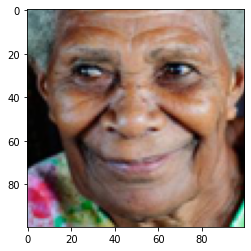

In [19]:
plt.imshow(X_test[i])

In [17]:
real_age = Y_test[i]

In [24]:
prediction_image = np.expand_dims(X_test[i], axis=0)
predicted_age = str(float(model_4.predict(prediction_image)))
# predicted_age = str(float(model.predict(prediction_image)[0]))



TypeError: ignored

In [ ]:
print("La edad real es {}, y la predicha es {}".format(real_age, predicted_age))

Text(0.5, 1.0, 'Edad real: 22 \n Edad predicha: 4781.713')

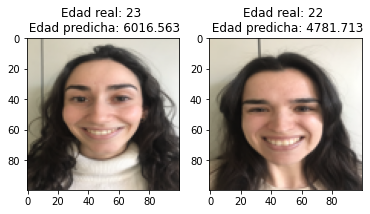

In [33]:
image_path_moni = os.getcwd() +"/IMG_MONI.png"
image_moni = Image.open(image_path_moni)
image_moni = image_moni.convert('RGB')
image_moni = image_moni.resize((width, height))
prediction_image_moni = np.expand_dims(image_moni, axis=0)
predicted_age_moni = float(model.predict(prediction_image_moni))

image_path_ana = os.getcwd() +"/IMG_ANA.png"
image_ana = Image.open(image_path_ana)
image_ana = image_ana.convert('RGB')
image_ana = image_ana.resize((width, height))
prediction_image_ana = np.expand_dims(image_ana, axis=0)
predicted_age_ana = float(model.predict(prediction_image_ana))

plt.subplot(1, 2, 1)
plt.imshow(np.array(image_moni))
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(23, predicted_age_moni))
plt.subplot(1, 2, 2)
plt.imshow(np.array(image_ana))
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(22, predicted_age_ana))

In [ ]:
image_path_chus = os.getcwd() +"/IMG_4990.png"
image_chus = Image.open(image_path_chus)
image_chus = image_chus.convert('RGB')
image_chus = image_chus.resize((width, height))
prediction_image_chus = np.expand_dims(image_chus, axis=0)
predicted_age_chus = float(model.predict(prediction_image_chus))

plt.subplot(1, 2, 1)
plt.imshow(np.array(image_chus))
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(22, predicted_age_chus))

In [ ]:
image_path_carlos = os.getcwd() +"/IMG_2767.png"
image_carlos = Image.open(image_path_carlos)
image_carlos = image_carlos.convert('RGB')
image_carlos = image_carlos.resize((width, height))
prediction_image_carlos = np.expand_dims(image_carlos, axis=0)
predicted_age_carlos = float(model.predict(prediction_image_carlos))

plt.subplot(1, 2, 1)
plt.imshow(np.array(image_carlos))
plt.title("Edad real: {} \n Edad predicha: {:.3f}".format(22, predicted_age_carlos))